# 章節 14：階層式模型

## 14.5 萃取後驗分佈

在我們更新完 Emitter 後，實作 Emitter.DistOfR 方法得到 r 的後驗分佈。

那要得到 n 的後驗分佈，我們必須要計算所有 Detector 的後驗分佈混合體。我們可以用 thinkbayes.MakeMixutre，這邊實作 Emitter.DistOfN 方法。

<pre>
# class Emitter
def DistOfR(self):
    # items 是 r 數值的序列跟對應的機率
    items = [(detector.r, prob) for detector, prob in self.Items()]
    
    # 用 items 產生 pmf 物件
    return thinkbayes.MakePmfFromItems(items)

# class Emitter
def DistOfN(self):
    return thinkbayes.MakeMixture(self)
</pre>

In [1]:
import thinkbayes as tb
import numpy as np
import matplotlib.pyplot as plt

def plot_dist(dist, c=None):
    x, y = zip(*sorted(dist.Items()))
    plt.plot(x, y, c=c)

class Detector(tb.Suite):
    
    def __init__(self, r, f, high=500, step=1):
        
        # r 表示平均發射頻率
        # high：最高可能的粒子數
        # step：發射量的間距
        
        # n 服從 Poisson 分佈
        pmf = tb.MakePoissonPmf(r, high, step=step)
        super().__init__(pmf, name=r)
        
        self.r = r
        self.f = f
    
    
    def Likelihood(self, data, hypo):
        # data: 多少顆粒被偵測到
        k = data
        
        # hypo: 假設發射出 n 顆粒子
        n = hypo
        
        # p: 偵測率
        p = self.f
        
        # 假設發出 n 顆粒子，在偵測率 p 的情況下，實際被偵測到 k 顆粒子的似然性
        return tb.EvalBinomialPmf(k, n, p)
    
    
    def SuiteLikelihood(self, data):
        total = 0
        
        for n, prob in self.Items():
            total += prob*self.Likelihood(data, n)
        
        return total
        
        

class Emitter(tb.Suite):
    
    def __init__(self, rs, f=0.1):
        # rs 是一序列的發射率 r
        
        # detectors 為一序列針對不同的 r 的 Detector 物件
        detectors = [Detector(r, f) for r in rs]
        
        # Emitter 分佈的數值是 Detectors 物件
        super().__init__(detectors)
    
    
    def DistOfR(self):
        items = [(detector.r, prob) for detector, prob in self.Items()]
        return tb.MakePmfFromItems(items)
    
    
    def DistOfN(self):
        return tb.MakeMixture(self)
    
    
    def Likelihood(self, data, hypo):
        detector = hypo
        # 這邊看到 data 的 likelihood 就是 detector 整個分佈的加權 likelihood
        # 請參考 Detector.SuiteLikelihood()
        # like = detector.SuiteLikelihood(data)
        
        # 直接更新每個 detector 的分佈，並且得到 detector 分佈的正規化常數
        like = detector.Update(data)
        return like
        
    # 將重載的 Updte 註解掉，因為用不到了
    #def Update(self, data):
    #    # 除了 Update 自己分佈的情況，也要 Update 每個子分佈
    #    super().Update(data)
    #    
    #    # Update 每個子分佈
    #    for detector in self.Values():
    #        detector.Update(data)

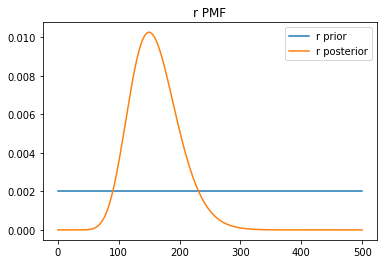

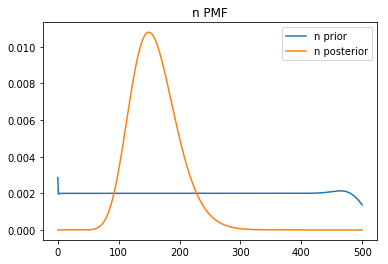

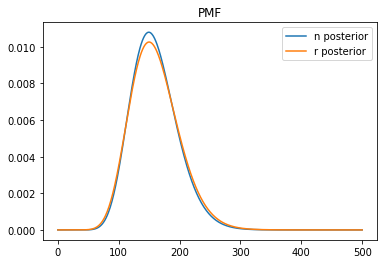

In [6]:
# 假設給定
f = 0.1
k = 15
rs = np.linspace(0.1, 500, 500) # 粒子數/秒
rate_dist = Emitter(rs)
prior_n = rate_dist.DistOfN()

plot_dist(rate_dist.DistOfR())
rate_dist.Update(k)
plot_dist(rate_dist.DistOfR())
plt.legend(["r prior", "r posterior"])
plt.title("r PMF")
plt.show()

plot_dist(prior_n)
plot_dist(rate_dist.DistOfN())
plt.legend(["n prior", "n posterior"])
plt.title("n PMF")
plt.show()

plot_dist(rate_dist.DistOfN())
plot_dist(rate_dist.DistOfR())
plt.legend(["n posterior", "r posterior"])
plt.title("PMF")
plt.show()

In [9]:
print("最有可能的 n 值：", rate_dist.DistOfN().MaximumLikelihood())
print("最有可能的 r 值：", rate_dist.DistOfR().MaximumLikelihood())

最有可能的 n 值： 150
最有可能的 r 值： 150.3705410821643


上圖為執行的結果。不意外的，n 最有可能的數值約落在 150。給定 f 和 n，期望的計數 k = f*n，所以給定 f 跟 k，則期望的 n = k/f = 15/0.1 = 150。

如果真實的情況是每秒射出 150 顆粒子，最有可能的 r 是 150/秒。

r 跟 n 的後驗分佈很相似；唯一的區別在我們對 n 稍微不確定。一般來說，我們可以比較確定遠距離的發射率 r，相較於在特定秒數的發射量 n。

你可以在此下載到作者個程式碼：http://thinkbayes.com/jaynes.py